# Linear Regression

In [ ]:
import os
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
plt.style.use('seaborn')

## Load Data

In [ ]:
def load_data(data_path):
    data = pd.read_csv(os.path.join(data_path, 'data_X.csv')).drop(['Serial_id'], axis=1)
    target = pd.read_csv(os.path.join(data_path, 'data_T.csv')).drop(['Serial_id'], axis=1)
    return data, target

DATA_DIR = '/content/drive/MyDrive/ColabNotebooks/簡仁宗 深度學習+機器學習/ML_HW1/dataset'
data, target = load_data(DATA_DIR)

# pd.dataframe to np.array
X, y = data.values, target.values
print(X.shape, y.shape)

(500, 7) (500, 1)


## Preprocessing

In [ ]:
class Preprocessing:

    def standar_normalize(self, X):
        """Standard Normalize"""
        mean = np.mean(X, axis=0)
        std = np.std(X, axis=0)
        return (X - mean) / std

    def minmax_normalize(self, X):
        """Min-Max Normalize"""
        max = np.amax(X, axis=0)
        min = np.amin(X, axis=0)
        return (X - min) / (max - min)
        
# preprocessing
preprocessing = Preprocessing()
X = preprocessing.standar_normalize(X)

## Basis Function

In [ ]:
class Basisfunction:
    def __init__(self, X):
        self.X = X
        self.mean = np.mean(self.X, axis=0)
        self.std = np.std(self.X, axis=0)
    
    def linear(self):
        return self.X

    def gaussian(self):
        return np.exp(-(self.X - self.mean)**2 / 2*self.std**2) 
    
    def sigmoid(self):
        return self._sigmoid((self.X - self.mean) / self.std)

    @staticmethod
    def _sigmoid(x):
        return 1 / (1 + np.exp(-x))

## Split Data

In [ ]:
def train_test_split(X, y, test_size=0.2, shuffle=False, random_state=None):
    """X shape: (sample_size, n_features)"""
    sample_size = X.shape[0]
    split_size = int(sample_size * test_size)

    if random_state is not None:
        np.random.seed(random_state)

    if shuffle:
        idx = np.arange(sample_size)
        np.random.shuffle(idx)
        X = X[idx]
        y = y[idx]

    # split data
    x_train, x_test = X[split_size:], X[:split_size]
    y_train, y_test = y[split_size:], y[:split_size]

    return x_train, x_test, y_train, y_test

## K-fold

In [ ]:
class KFold:
    def __init__(self, n_splits=3, *, shuffle=False, random_state=None):
        
        if n_splits <= 1:
            raise ValueError("train/test split by setting n_splits=2 or more")

        if not shuffle and random_state is not None:  # None is the default
            raise ValueError('Setting a random_state has no effect since shuffle is False.')

        self.n_splits = n_splits
        self.shuffle = shuffle
        self.random_state = random_state
    
    def get_n_splits(self):
        return self.n_splits

    def split(self, X):
        """return list of k-fold ideices for train and test"""
        self.n_samples = len(X)
        self.indices = np.arange(self.n_samples)
        train_list = []
        test_list = []

        if self.shuffle:
            np.random.RandomState(self.random_state).shuffle(self.indices)

        for test_index in self.test_mask():
            training_index = self.indices[np.logical_not(test_index)]
            testing_index = self.indices[(test_index)]
            train_list.append(training_index)
            test_list.append(testing_index)

        return train_list, test_list
        
    
    def test_mask(self):
        mask_list = []
        for test_index in self.test_indices(): 
            test_mask = np.zeros(self.n_samples, dtype=bool)
            test_mask[test_index] = True
            mask_list.append(test_mask)

        return mask_list
    
    def test_indices(self):
        n_splits = self.n_splits
        fold_sizes = np.full(n_splits, self.n_samples//n_splits, dtype=int)
        fold_sizes[:self.n_samples % n_splits] += 1
        current = 0
        test_idx = []
        for fold_size in fold_sizes:
            start, stop = current, current + fold_size
            test_idx.append(self.indices[start:stop])
            current = stop
        
        return test_idx

## Polynomial Features

In [ ]:
import numpy as np

def factorial(n):
    return np.array([1 if (n==1 or n==0) else n * factorial(n - 1)])

class PolynomialFeatures:

    def __init__(self, degree=2):
        self.degree = degree

    def fit(self, X):
        """
        X shape (N, M),
        N is sample size and M is feature size.
        output = (n+d)!/d!n!
        """
        self.n_features = X.shape[1]
        # calculate number of output feature size
        numerator = factorial(self.n_features + self.degree)
        denominator = factorial(self.degree) * factorial(self.n_features)
        self.n_output_features = int(numerator / denominator) - 1
    
    def transform(self, X):
        """transform to new features"""
        # combos is list of tuples indices to calculate polynomial features
        combos = [itertools.combinations_with_replacement(range(self.n_features), idx)
                for idx in range(1, self.degree+1)]
        # Create list of tuples containing feature index combinations.
        combinations = [item for sublist in combos for item in sublist]
        # to store new array from transformation
        X_new = np.empty((X.shape[0], self.n_output_features))

        for i, index_combos in enumerate(combinations):
            # np.pord can product specific axis
            X_new[:, i] = np.prod(X[:, index_combos], axis=1)

        return X_new
    
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

## Linear Regression Model

In [ ]:
import numpy as np


def rmse(y_true, y_pred):
        return np.sqrt(np.mean((y_true - y_pred)**2))


def accuracy(y_true, y_pred):
    """precision can definite by yourself"""
    precision = np.std(y_true) # using one standard diveation as bound
    pred_acc = np.absolute(y_pred - y_true) < precision
    return 100 * np.mean(pred_acc) # return percentage


class LinearRegression:
    """Linear Regression
    There are two method to find parameters:
    if ls_method = True, model will using least squares solution,
    if ls_method = False, model will using gradient decent.
    """
    def __init__(self, lr=0.001, n_iter=1000, beta=0):
        """ LinearRegression + Regularization 
        beta is regularization hyper-parameters,
        beta defalt is 0 which means not using regularization.
        """
        self.beta = beta
        self.lr = lr
        self.n_iter = n_iter
        self.weights = None
        self.bias = None
    
    def fit(self, X, y, *, ls_method=False, clip_gradient=False):
        self.clip_gradient = clip_gradient
        self.sample_size, self.n_features = X.shape

        # Usning Normal Equation to find w*, b*
        if ls_method:
            # update parameters
            self.bias, self.weights = self.least_squares_solution(X, y)
        
        # Gradient Decent
        else:
            # inintialize weight
            self.weights = np.random.randn(self.n_features, 1)
            self.bias = 0
            
            # training loop
            for _ in range(self.n_iter):
                self.update_param(X, y)

    def predict(self, X):
        return np.dot(X, self.weights) + self.bias
    
    def least_squares_solution(self, X, y):
        """return least squares solution
        note. invers_term will add a small number to make noise,
        this can help find inverse of inv(phi*phi).
        """
        bias_inputs = np.ones((self.sample_size, 1))
        phi = np.concatenate((bias_inputs, X), axis=1)
        invers_term = np.linalg.inv(self.beta * np.eye(self.n_features+1) + np.dot(phi.T, phi) 
            + 1e-7 * np.random.randn(self.n_features+1))
        w = np.dot(invers_term, np.dot(phi.T, y))
        return w[0], w[1:]
    
    def update_param(self, X, y):
        y_hat = np.dot(X, self.weights) + self.bias # 500x1

        # differential weight & bias
        dw =(1/self.sample_size) * np.dot(X.T, (y_hat - y)) + self.beta*self.weights # 7x1
        db =(1/self.sample_size) * np.sum(y_hat - y)
        
        # clip gradient to prevent gradient exploding
        if self.clip_gradient:
            dw = np.clip(dw, 1e-7, 1)
            db = np.clip(db, 1e-7, 1)

        # update parameters
        self.weights -= self.lr * dw
        self.bias -= self.lr * db

## **2-1 Feature select**

### (a) Evaluate the corresponding RMS error

**M = 1**

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=1)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(400, 7) (400, 1)
(100, 7) (100, 1)


In [ ]:
# create Linear Regression model
model = LinearRegression()
model.fit(x_train, y_train, ls_method=True)

# Root-mean square error
y_pred = model.predict(x_train)
acc = accuracy(y_train, y_pred)
print(f'training RMSE: {rmse(y_train, y_pred)}')
# # print(f'training acc: {acc}%')
y_pred = model.predict(x_test)
acc = accuracy(y_test, y_pred)
print(f'testing RMSE: {rmse(y_test, y_pred)}')
# # print(f'testing acc: {acc}%')

training RMSE: 0.05977752557506849
testing RMSE: 0.05881410458595826


**M = 2**

In [ ]:
transform = PolynomialFeatures(degree=2)
X_M2 = transform.fit_transform(X)
x_train, x_test, y_train, y_test = train_test_split(X_M2, y, test_size=0.2, shuffle=True, random_state=1)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(400, 35) (400, 1)
(100, 35) (100, 1)


In [ ]:
# create Linear Regression model
model_M2 = LinearRegression()
model_M2.fit(x_train, y_train, ls_method=True)

# Root-mean square error
y_pred = model_M2.predict(x_train)
acc = accuracy(y_train, y_pred)
print(f'training RMSE: {rmse(y_train, y_pred)}')
# print(f'training acc: {acc}%')
y_pred = model_M2.predict(x_test)
acc = accuracy(y_test, y_pred)
print(f'testing RMSE: {rmse(y_test, y_pred)}')
# print(f'testing acc: {acc}%')

training RMSE: 0.05707448002047349
testing RMSE: 0.05833226919481011


### (b) Analysis M=1 and select the most contributive feature

因為 model 是線性的，因此 feature 的參數就是對 model 的解釋力，

參數越大代表解釋力越好，即貢獻度越高，

由下表的結果可以發現， 	**CGPA** **is the most contributive feature.** 

In [ ]:
from prettytable import PrettyTable

table = PrettyTable()
table.title = 'Feature select'
table.add_column('Features', *[list(data.columns)])
table.add_column('Weights', np.round(*[model.weights.flatten().tolist()], 5))
print(table)

+-----------------------------+
|        Feature select       |
+-------------------+---------+
|      Features     | Weights |
+-------------------+---------+
|     GRE_score     | 0.02067 |
|    TOFEL_score    | 0.01928 |
| University_rating |  0.007  |
|        SOP        | 0.00298 |
|        LOR        | 0.01334 |
|        CGPA       | 0.07051 |
|      Research     | 0.00987 |
+-------------------+---------+


## **2-2 Maximum likelihood approach**

### (a) Which basis function will you use?

我先將 inputs 做 **Standard Normalization** 再使用 **sigmoid basis function** 做轉換，

之後再將轉換完的數據進行 Linear Regression 分析.



### (b) Using basis function and analyze the result

In [ ]:
X, y = data.values, target.values

# preprocessing
preprocessing = Preprocessing()
X = preprocessing.standar_normalize(X)

# make design matrix phi
basis_fn = Basisfunction(X)
X = basis_fn.sigmoid()

# split train test
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=1)

# create Linear Regression model
model_M = LinearRegression()
model_M.fit(x_train, y_train, ls_method=True)

# Root-mean square error
train_pred = model_M.predict(x_train)
test_pred = model_M.predict(x_test)

print(f'【After using basis function】 training RMSE: {rmse(y_train, train_pred)}, \
    testing RMSE: {rmse(y_test, test_pred)}')

【After using basis function】 training RMSE: 0.06074337426405264,     testing RMSE: 0.06006682258905472


### (c)  N-fold cross-validation to choise hyper-parameters

N 設為 3

In [ ]:
X, y = data.values, target.values
# preprocessing
preprocessing = Preprocessing()
X = preprocessing.standar_normalize(X)
# Basisfunction
basis_fn = Basisfunction(X)
X = basis_fn.sigmoid()

# k-fold cross-validattion index list
kf = KFold(n_splits=3, shuffle=True, random_state=1)
training_indices, test_indices = kf.split(X)

total_trian_rmse = []
total_test_rmse = []
for m in tqdm(range(1, 10)):
    train_rmse = []
    test_rmse = []
    for train_idx, test_idx in zip(training_indices, test_indices):
        transform = PolynomialFeatures(degree=m)
        polynomial_x = transform.fit_transform(X)
        x_train, x_test = polynomial_x[train_idx], polynomial_x[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # create Linear Regression model
        model_polynomial = LinearRegression()
        model_polynomial.fit(x_train, y_train, ls_method=True)

        # Root-mean square error
        train_pred = model_polynomial.predict(x_train)
        test_pred = model_polynomial.predict(x_test)
        train_rmse.append(rmse(y_train, train_pred))
        test_rmse.append(rmse(y_test, test_pred))
    
    average_train_rmse = sum(train_rmse) / len(training_indices)
    average_test_rmse = sum(test_rmse) / len(training_indices)
    total_trian_rmse.append(average_train_rmse)
    total_test_rmse.append(average_test_rmse)
    print(f'【M = {m}】 training RMSE: {average_train_rmse}, testing RMSE: {average_test_rmse}')

【M = 1】 training RMSE: 0.060061399256568095, testing RMSE: 0.06279045003152113
【M = 2】 training RMSE: 0.05694133781398183, testing RMSE: 0.06368960644806143
【M = 3】 training RMSE: 3.6107705562782315, testing RMSE: 3.5811060523005183
【M = 4】 training RMSE: 15.80237924347488, testing RMSE: 16.89757156051215
【M = 5】 training RMSE: 29.53726827599218, testing RMSE: 42.440672344790585
【M = 6】 training RMSE: 32.43550959296301, testing RMSE: 40.7529188036322
【M = 7】 training RMSE: 87.63760015570823, testing RMSE: 319.02224436529406
【M = 8】 training RMSE: 193.81791697795006, testing RMSE: 660.8978568800047
【M = 9】 training RMSE: 1536.8052273719368, testing RMSE: 6049.26710657193



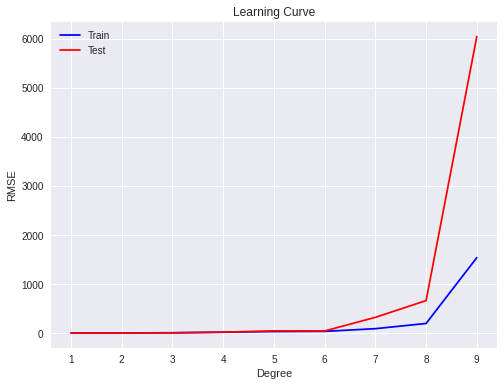

In [ ]:
# plot learning cruve
x_axis = range(1, len(total_trian_rmse)+1)
plt.figure(figsize=(8,6))
plt.plot(x_axis, total_trian_rmse, c='b', label="Train")
plt.plot(x_axis, total_test_rmse, c='r', label='Test')
plt.title('Learning Curve')
plt.xlabel('Degree')
plt.ylabel('RMSE')
plt.xticks(ticks=x_axis)
plt.legend()
plt.show()

## **2-3 Maximum a posterior approach**


### (a) Difference between ML and MAP

ML approach 和 MAP 最大的差別在於 **『MAP 有 prior,因此 MAP 不完全受 Data 的噪音所影響』**

ML approach 會完全依照數據給的資訊來找最可能的結果，而 MAP 會結合 prior 資訊和 data 資訊，再根據彼此的權重去加權平均，所以 MAP 的結果會剛好落在 ML 和
prior 之間。

綜合來說，ML approach 完全仰賴數據所以容易 overfitting ，以至於 model 在 testing set 的表現不太好，除非數據非常大量；

相反地，MAP 因為有 prior 的保護，使得其結果不像 ML approach 來得極端。


### (b) Using MAP to retest model in 2-2(b)

Regularization parameter **Beta = 0.01**

In [ ]:
X, y = data.values, target.values
# preprocessing
preprocessing = Preprocessing()
X = preprocessing.standar_normalize(X)
# Basisfunction
basis_fn = Basisfunction(X)
X = basis_fn.sigmoid()

# k-fold cross-validattion index list
kf = KFold(n_splits=3, shuffle=True, random_state=1)
training_indices, test_indices = kf.split(X)

train_rmse = []
test_rmse = []
train_rmse_regularization = []
test_rmse_regularization = []
for m in tqdm(range(1, 10)):
    transform = PolynomialFeatures(degree=m)
    polynomial_x = transform.fit_transform(X)
    x_train, x_test = polynomial_x[train_idx], polynomial_x[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # create Linear Regression model
    model = LinearRegression()
    model.fit(x_train, y_train, ls_method=True)
    # create Linear Regression model + Regularization(beta)
    model_regularization = LinearRegression(beta=0.01)
    model_regularization.fit(x_train, y_train, ls_method=True)

    # Root-mean square error
    train_pred = model.predict(x_train)
    test_pred = model.predict(x_test)
    train_pred_regularization = model_regularization.predict(x_train)
    test_pred_regularization = model_regularization.predict(x_test)
    train_rmse.append(rmse(y_train, train_pred))
    test_rmse.append(rmse(y_test, test_pred))
    train_rmse_regularization.append(rmse(y_train, train_pred_regularization))
    test_rmse_regularization.append(rmse(y_test, test_pred_regularization))
    
    print(f'【no prior M = {m}】 training RMSE: {rmse(y_train, train_pred):.5f}, testing RMSE: {rmse(y_test, test_pred):.5f}')
    print(f'【using prior M = {m}】 training RMSE: {rmse(y_train, train_pred_regularization):.5f}, testing RMSE: {rmse(y_test, test_pred_regularization):.5f}')
    print()

【no prior M = 1】 training RMSE: 0.05885, testing RMSE: 0.06595
【using prior M = 1】 training RMSE: 0.05885, testing RMSE: 0.06596

【no prior M = 2】 training RMSE: 0.05583, testing RMSE: 0.06575
【using prior M = 2】 training RMSE: 0.05591, testing RMSE: 0.06554

【no prior M = 3】 training RMSE: 0.62854, testing RMSE: 0.65782
【using prior M = 3】 training RMSE: 0.05093, testing RMSE: 0.06621

【no prior M = 4】 training RMSE: 10.90787, testing RMSE: 11.12608
【using prior M = 4】 training RMSE: 0.04883, testing RMSE: 0.06974

【no prior M = 5】 training RMSE: 8.01582, testing RMSE: 9.28983
【using prior M = 5】 training RMSE: 0.04771, testing RMSE: 0.07303

【no prior M = 6】 training RMSE: 41.81095, testing RMSE: 54.84475
【using prior M = 6】 training RMSE: 0.04654, testing RMSE: 0.07606

【no prior M = 7】 training RMSE: 373.81061, testing RMSE: 776.93226
【using prior M = 7】 training RMSE: 0.04532, testing RMSE: 0.07932

【no prior M = 8】 training RMSE: 1103.21049, testing RMSE: 3236.48526
【using prior 

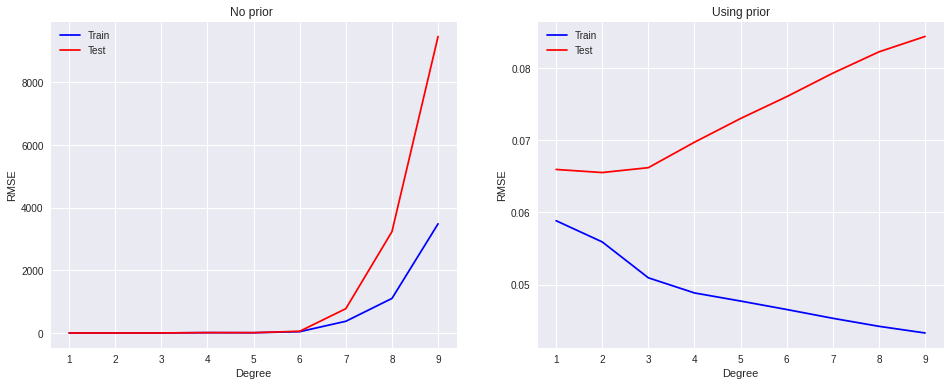

In [ ]:
# plot learning cruve
x_axis = range(1, len(train_rmse)+1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))

# no prior 
ax1.plot(x_axis, train_rmse, c='b', label="Train")
ax1.plot(x_axis, test_rmse, c='r', label='Test')
ax1.set_title('No prior ')
ax1.set_xlabel('Degree')
ax1.set_ylabel('RMSE')
ax1.set_xticks(ticks=x_axis)
ax1.legend()

# had prior
ax2.plot(x_axis, train_rmse_regularization, c='b', label="Train")
ax2.plot(x_axis, test_rmse_regularization, c='r', label='Test')
ax2.set_title('Using prior')
ax2.set_xlabel('Degree')
ax2.set_ylabel('RMSE')
ax2.set_xticks(ticks=x_axis)
ax2.legend()
plt.show()

### (c) Compare the result between ML and MAP

由 (b) 的結果可以發現 MAP 的 training 和 validation **差異變小**了，

當沒有 prior 控制時，隨著 polynomial order 越來越大， over-fitting 也越嚴重；

當有 prior 控制時，即便 polynomial order 越來越大，雖然一樣會有 over-fitting，但 **over-fitting 的速度很明顯地變慢了 !**

從實驗的結果可發現， **prior 確實能保護 model 對新數據進行預測，使得 training set 和 testing set 的準確度不會相差太大**。